# Case X.
Lauri Marjanen & Jesse Jyrälä, Team 10<br>
Neural Networks for Machine Learning Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

In [138]:
# Required libraries
import numpy as np
%pylab inline
import os
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, Dropout, Conv1D, GlobalAveragePooling1D, Dense, SimpleRNN

from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical




print(f'Tensorflow version {tf.__version__}')

Populating the interactive namespace from numpy and matplotlib
Tensorflow version 2.7.0


C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Data

In [139]:
train = pd.read_csv(os.getcwd() + '/input/drugsComTrain_raw.csv')
test = pd.read_csv(os.getcwd() + '/input/drugsComTest_raw.csv')

In [140]:
%%time

maxFeat = 5000
seqLen = 100

samples = train['review']
tokenizer = Tokenizer(maxFeat)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

wordIndx = tokenizer.word_index
data = pad_sequences(sequences,seqLen)

print("Token count: ", len(wordIndx))
print("Shape: ", data.shape)

Token count:  51429
Shape:  (161297, 100)
Wall time: 27.1 s


In [141]:
ratings = train['rating'].values
labels = 1.0*(ratings >= 8) + 1.0*(ratings >= 5)
hotLabels = to_categorical(labels)
print("Shape of lables", hotLabels.shape)

Shape of lables (161297, 3)


## MODEL

In [142]:
valSplit = 0.30 # 70/15/15 split
testSplit = 0.50
N1 = int(valSplit * data.shape[0])
N2 = int(testSplit * data.shape[0])
index = np.arange(data.shape[0])
np.random.shuffle(index)
data = data[index]
hotLabels = hotLabels[index]

trainData = data[:N1]
trainCat = hotLabels[:N1]
valData = data[N1:N2]
valCat = hotLabels[N1:N2]
testData =data[N2:]
testCat = hotLabels[N2:]

In [143]:
outDimension = 100

model = Sequential([
    Embedding(maxFeat +1, outDimension),
    Dropout(0.2),
    Conv1D(128,7, padding="valid", activation= "relu", strides=3),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(128,activation="relu"),
    Dense(3,activation="softmax")
])
model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 100)         500100    
                                                                 
 dropout_24 (Dropout)        (None, None, 100)         0         
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         89728     
                                                                 
 global_average_pooling1d_12  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                     

In [144]:
EPOCHS = 4
VERBOSE = 0

In [145]:
%%time
hist= model.fit(trainData, trainCat,
                batch_size=128*2,
                epochs=EPOCHS,
                verbose=VERBOSE,
                validation_data=(valData,valCat)
                )

Wall time: 46.1 s


# Results and Discussion

The following results were achieved ...

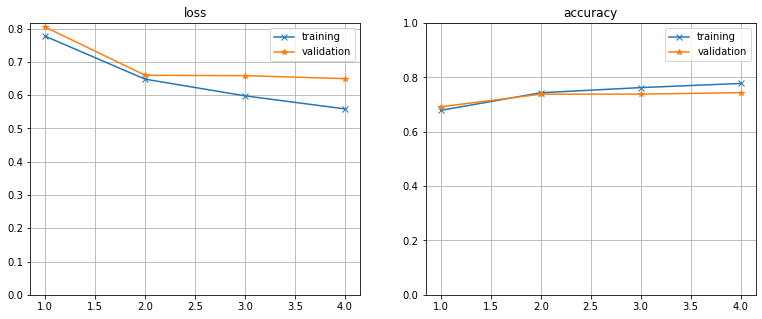

In [146]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure, subplot, plot, title, ylim, legend, grid

x_axis = np.arange(len(hist.history['loss'])) + 1


figure(figsize(13,5))
subplot(1,2,1)
plot(x_axis, hist.history['loss'], 'x-', label = 'training')
plot(x_axis, hist.history['val_loss'], '*-', label = 'validation')
title('loss')
ylim(0,)
legend()
grid()


subplot(1,2,2)
plot(x_axis, hist.history['acc'], 'x-', label = 'training')
plot(x_axis, hist.history['val_acc'], '*-', label = 'validation')

title('accuracy')
ylim(0,1.0)
legend()
grid()

In [147]:
result = model.evaluate(testData,testCat, verbose=VERBOSE)
print("Test accuracy: ", round(100 * result[1], 3 ))

Test accuracy:  74.244


In [148]:
from sklearn.metrics import cohen_kappa_score

pred_labels = np.argmax(model.predict(testData),axis=1)
test_labels = np.argmax(testCat, axis = 1)

k = cohen_kappa_score(test_labels,pred_labels)
print("Chohen's kappa linear", k)

k = cohen_kappa_score(test_labels,pred_labels, weights='quadratic')
print("Chohen's kappa quadratic", k)

Chohen's kappa linear 0.5075146485227653
Chohen's kappa quadratic 0.6331767552014256


# Conclusions

For this case study we found that a simple model gave the best results, ~74% accuracy 0.5 kohen kappa, 0.62 kohen kappa quadratic.
Most of the improvements to model came in form of very large epoch time decreases, from 40 sec to 11 sec per epoch. We tried using full dense model, sparse, RNN and LTSM models with worse results. for data-augmentation we tried normalization and text sanitation but that yielded no results. 